<a href="https://colab.research.google.com/github/leobioinf0/jump2digital2023/blob/main/jump2digital_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descripción del proyecto
En esta prueba técnica dispondrás de tres conjuntos de datos:
1. Presenta información sobre la media del alquiler mensual (€/mes) y por superficie (€/m2) de la ciudad de Barcelona: Alquiler mensual medio (€/mes) y por superficie (€/m2) de la ciudad de Barcelona - [2017_Alquiler_precio_trim.csv](https://opendata-ajuntament.barcelona.cat/data/es/dataset/est-mercat-immobiliari-lloguer-mitja-mensual/resource/0a71a12d-55fa-4a76-b816-4ee55f84d327) - Open Data Barcelona
2. Contiene información sobre la exposición a los ruidos de la población, del Mapa Estratégico de Ruido de la ciudad de Barcelona: Población expuesta en los niveles de ruido del Mapa Estratégico de Ruido de la ciudad de Barcelona - [2017_Poblacio_exposada_barris_Mapa_Estrategic_Soroll_BCN_LONG.csv](https://opendata-ajuntament.barcelona.cat/data/es/dataset/poblacio-exposada-mapa-estrategic-soroll/resource/3846500e-72aa-4780-967f-f09aa184eaba) - Open Data
Barcelona
3. Proporciona información sobre los accidentes de tráfico gestionados por la Guardia Urbana en la ciudad de Barcelona: Accidentes según causa conductor gestionados por la Guardia Urbana en la ciudad de Barcelona - [2017_ACCIDENTS_CAUSA_CONDUCTOR_GU_BCN_.csv](https://opendata-ajuntament.barcelona.cat/data/ca/dataset/accidents_causa_conductor_gu_bcn/resource/1a05cdd4-4844-41a5-872d-a0824d11b517?inner_span=True) -
Open Data Barcelona



# Tu misión en esta prueba es:
1. Seleccionar dos conjuntos de datos y unificarlos teniendo en cuenta que nuestro conjunto
base es el de los alquileres.
2. Realizar el preprocesamiento de datos necesario para garantizar que los datos sean precisos.
3. Aplicar un análisis de componentes principales para reducir las dimensiones del conjunto de
datos.



# Evaluación
- Correcta depuración de los datos. Deberás realizar la estandarización y/o normalización de las
variables que lo requieran.
- Seleccionar una muestra del conjunto de datos unificados.
- Correcta documentación del proceso. Se evaluará la legibilidad, organización y buenas
prácticas de programación.
- Correcta interpretación de los resultados.


# Entrega
Tienes que entregar la prueba técnica a través de un enlace a tu repositorio de GitHub. En el
repositorio, debes incluir:
- Un archivo Jupyter Notebook con todas las líneas de código ejecutadas y las interpretaciones
que consideres necesarias.
- Un archivo README con la siguiente información:
    1. Introducción: Presentación del conjunto de datos y de las variables seleccionadas.
    2. Depuración de datos: Descripción detallada de las técnicas de preprocesado aplicadas y los criterios de evaluación utilizados.
    3. Resultados: Presentación de los resultados obtenidos.
    4. Conclusiones: Principales inferencias derivadas de los resultados conseguidos.

# import

In [48]:
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from IPython.display import HTML
from matplotlib import animation
from joblib import dump, load
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor,RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import ARDRegression, BayesianRidge, HuberRegressor, LinearRegression, PassiveAggressiveRegressor, PoissonRegressor, SGDRegressor, TheilSenRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.svm import SVR

# def

In [1]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

def price_imputer(df, name):
    for LloguerMitja in df.LloguerMitja.unique():
        imputer = IterativeImputer(max_iter=4, random_state=0)
        imputer.fit(pd.get_dummies(df.loc[(df.NomDistricte==name)&(df.LloguerMitja==LloguerMitja),['Trimestre', 'CodiDistricte', 'CodiBarri', 'NomBarri', 'Preu']]))
        df.loc[(df.NomDistricte==name)&(df.LloguerMitja==LloguerMitja),["Preu"]] = imputer.transform(pd.get_dummies(df.loc[(df.NomDistricte==name)&(df.LloguerMitja==LloguerMitja),['Trimestre', 'CodiDistricte', 'CodiBarri', 'NomBarri', 'Preu']]))[:,0].round(2)
    return df

def animate(frame):
  ax.view_init(elev=30, azim=frame)
  plt.pause(.01)
  return fig

# 2017_lloguer_preu_trim

In [3]:
precio = pd.read_csv("https://opendata-ajuntament.barcelona.cat/data/dataset/69c3250b-100c-4d5b-a08e-0a191d9950e3/resource/0a71a12d-55fa-4a76-b816-4ee55f84d327/download/2017_lloguer_preu_trim.csv")
precio.rename(columns=lambda x: x.strip().replace("_", " ").title().replace(" ", ""), inplace=True)
precio.LloguerMitja.replace({"Lloguer mitjà mensual (Euros/mes)":"Mes","Lloguer mitjà per superfície (Euros/m2 mes)":"M2Mes"}, inplace=True)
precio.loc[:,precio.select_dtypes('int').columns] = precio.select_dtypes('int').astype("category")
precio[["LloguerMitja"]] = precio.loc[:,["LloguerMitja"]].astype("category")
precio.head(2)

,Any,Trimestre,CodiDistricte,NomDistricte,CodiBarri,NomBarri,LloguerMitja,Preu
0,2017,1,1,Ciutat Vella,1,el Raval,Mes,734.99
1,2017,1,1,Ciutat Vella,2,el Barri Gòtic,Mes,905.26


In [4]:
# Checking the number of unique values
precio.nunique()

Any                1
Trimestre          4
CodiDistricte     10
NomDistricte      10
CodiBarri         73
NomBarri          73
LloguerMitja       2
Preu             504
dtype: int64

In [5]:
# Remove variable "Any"
precio.drop(columns=["Any"], inplace=True)

In [6]:
# Checking the categorical unique values in "Trimestre"
precio["Trimestre"].unique()

[1, 2, 3, 4]
Categories (4, int64): [1, 2, 3, 4]

In [7]:
# Checking "CodiDistricte" and "NomDistricte"
precio[["CodiDistricte", "NomDistricte"]].drop_duplicates()

,CodiDistricte,NomDistricte
0,1,Ciutat Vella
4,2,Eixample
10,3,Sants-Montjuïc
18,4,Les Corts
21,5,Sarrià-Sant Gervasi
27,6,Gràcia
32,7,Horta-Guinardó
43,8,Nou Barris
56,9,Sant Andreu
63,10,Sant Martí


In [8]:
# Checking "CodiBarri" and "NomBarri"
precio[["CodiBarri", "NomBarri"]].drop_duplicates()

,CodiBarri,NomBarri
0,1,el Raval
1,2,el Barri Gòtic
2,3,la Barceloneta
3,4,"Sant Pere, Santa Caterina i la Ribera"
4,5,el Fort Pienc
...,...,...
68,69,Diagonal Mar i el Front Marítim del Poblenou
69,70,el Besòs i el Maresme
70,71,Provençals del Poblenou
71,72,Sant Martí de Provençals


In [9]:
# Checking if there are any null values
# None are found!
precio.isnull().sum()

Trimestre         0
CodiDistricte     0
NomDistricte      0
CodiBarri         0
NomBarri          0
LloguerMitja      0
Preu             38
dtype: int64

In [10]:
precio.loc[(precio.Preu.isna())].groupby(["NomDistricte", "NomBarri"])[["LloguerMitja"]].count().rename(columns={"LloguerMitja":"number of nulls"})

number of nulls
NomDistricte   NomBarri                                   
Horta-Guinardó la Clota                                  8
Nou Barris     Can Peguera                               6
               Torre Baró                                2
               Vallbona                                  6
Sant Andreu    Baró de Viver                             8
Sants-Montjuïc la Marina del Prat Vermell                8

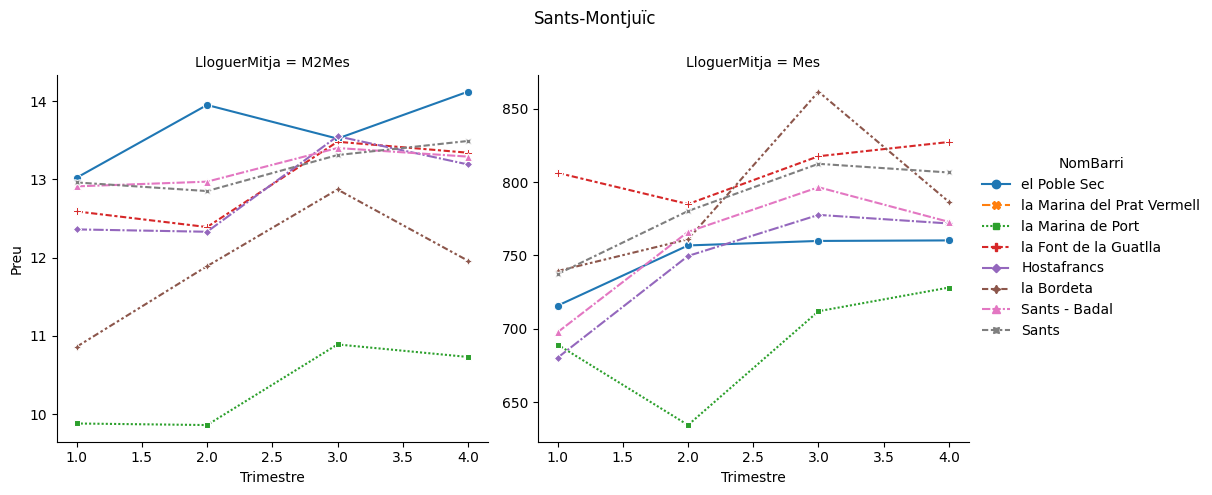

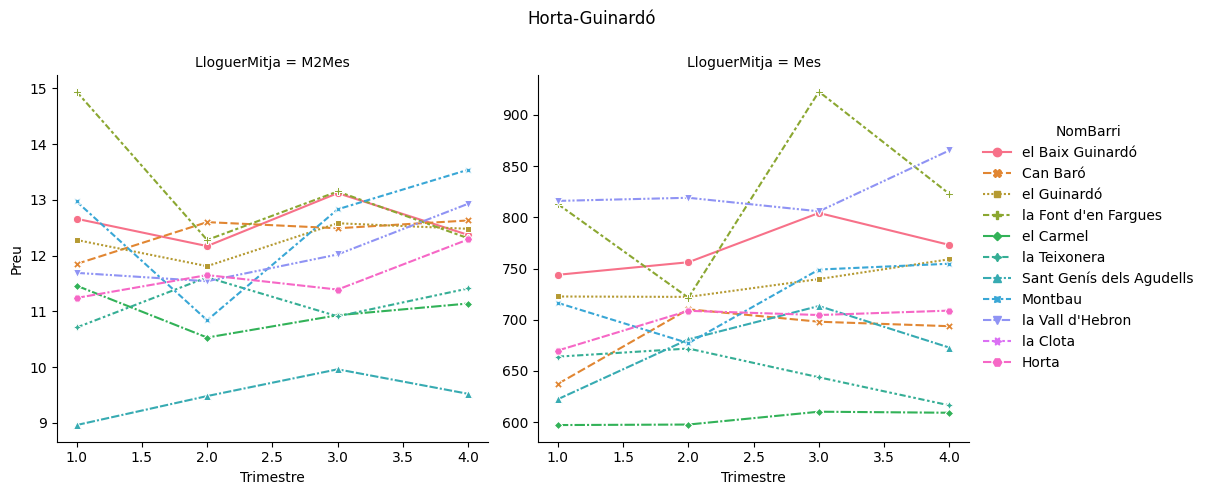

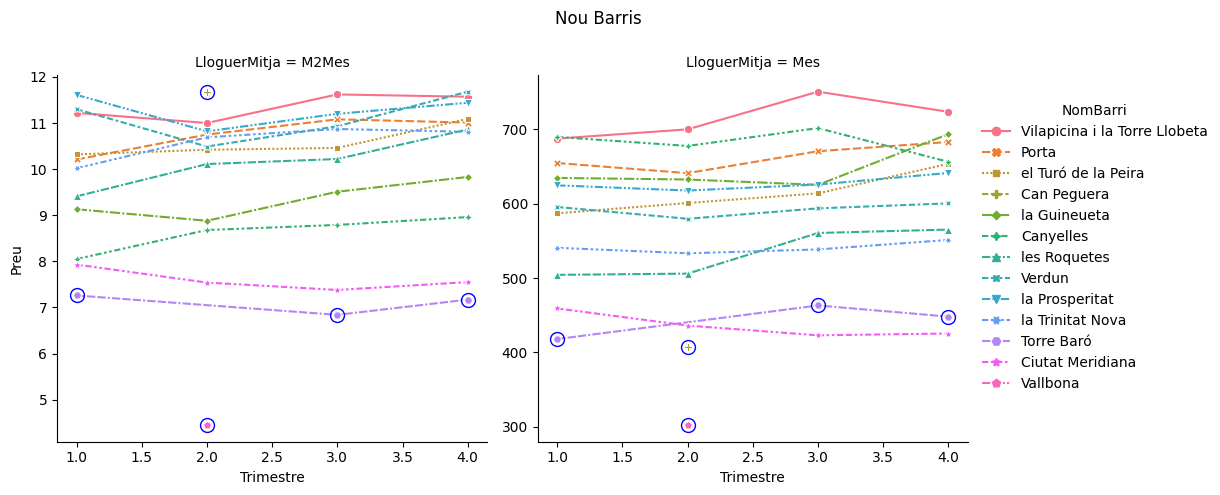

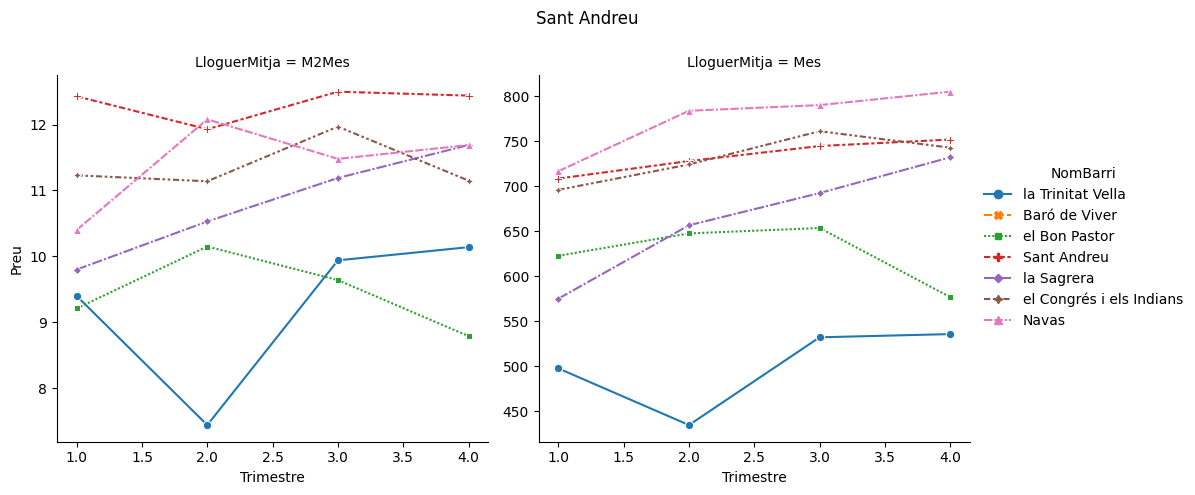

In [11]:
Districtes_imput = precio.loc[(precio.Preu.isna()), "NomDistricte"].unique()
Barris_imput = precio.loc[(precio.Preu.isna()), "NomBarri"].unique()

for Districte_imput in Districtes_imput:
    ax = sns.relplot(data=precio.loc[precio.NomDistricte==Districte_imput], kind="line",x="Trimestre", y="Preu",
                 hue="NomBarri", style="NomBarri",col="LloguerMitja",dashes=True, markers=True,facet_kws=dict(sharey=False))
    ax.fig.subplots_adjust(top=.85)
    ax.fig.suptitle(Districte_imput)
    Barri_imput = precio.loc[(precio.NomBarri.isin(Barris_imput)) & (precio.NomDistricte==Districte_imput), "NomBarri"].unique()
    for idx, row in precio.loc[(precio.NomBarri.isin(Barri_imput)) &(precio.LloguerMitja=="M2Mes")].iterrows():
        ax.facet_axis(0, 0).plot([row.Trimestre],[row.Preu],'o',ms=10,mec='b',mfc='none')
    for idx, row in precio.loc[(precio.NomBarri.isin(Barri_imput)) &(precio.LloguerMitja=="Mes")].iterrows():
        ax.facet_axis(0, 1).plot([row.Trimestre],[row.Preu],'o',ms=10,mec='b',mfc='none')

In [15]:
for District in precio.loc[(precio.Preu.isna()), "NomDistricte"].unique():
    precio = price_imputer(precio, District)
del District

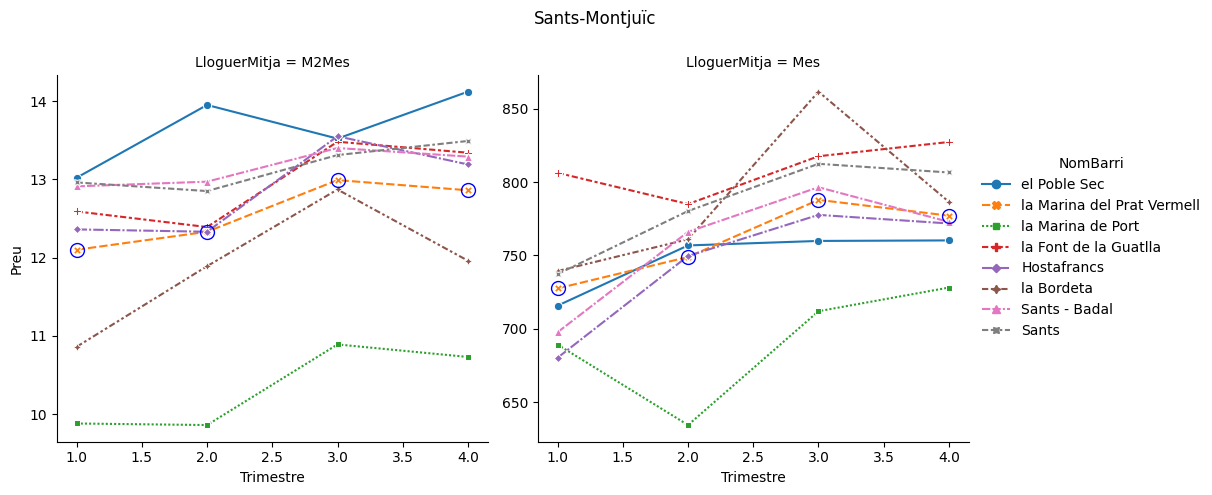

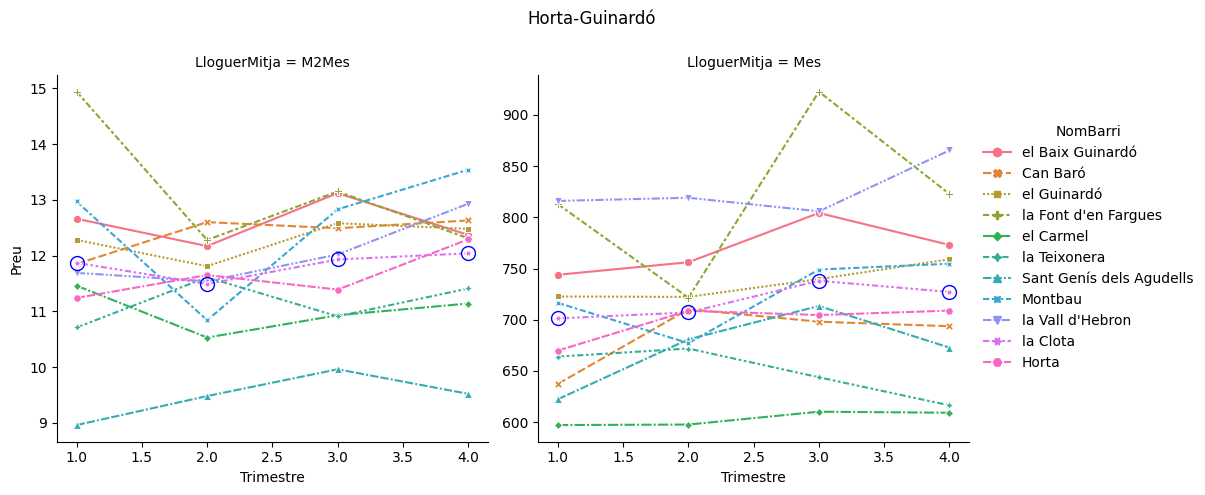

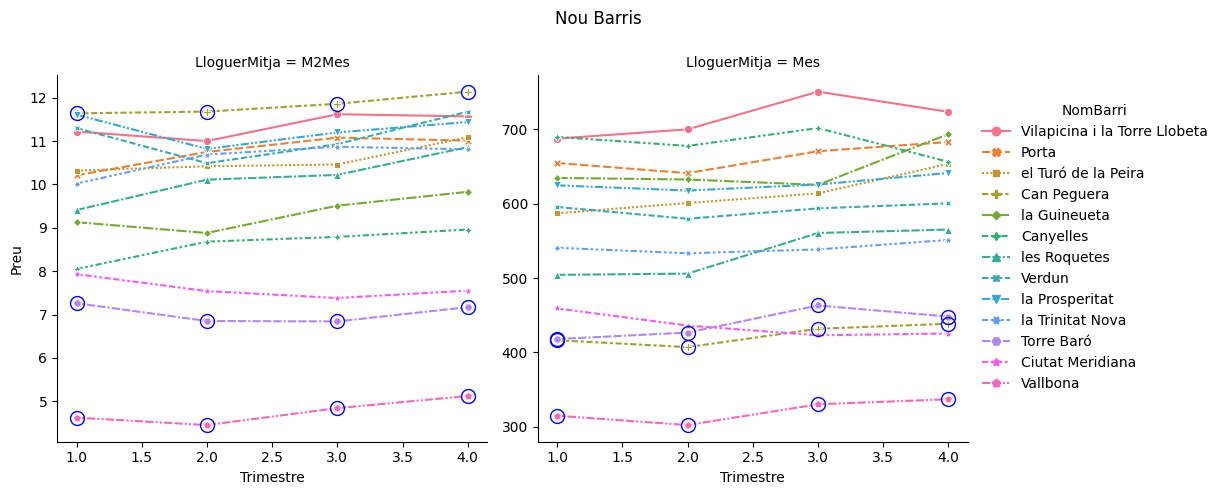

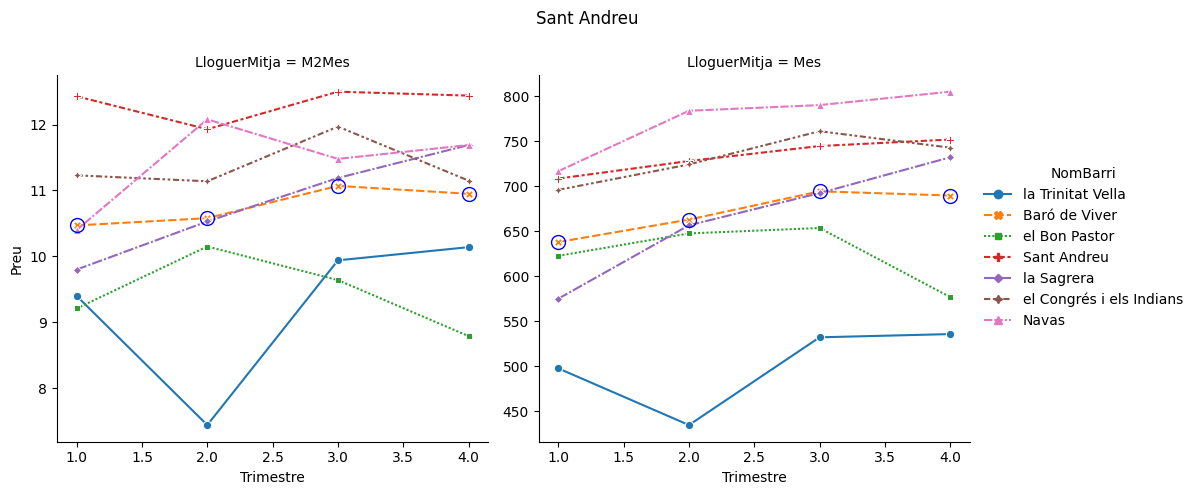

In [16]:
for Districte_imput in Districtes_imput:
    ax = sns.relplot(data=precio.loc[precio.NomDistricte==Districte_imput], kind="line",x="Trimestre", y="Preu",
                 hue="NomBarri", style="NomBarri",col="LloguerMitja",dashes=True, markers=True,facet_kws=dict(sharey=False))
    ax.fig.subplots_adjust(top=.85)
    ax.fig.suptitle(Districte_imput)
    Barri_imput = precio.loc[(precio.NomBarri.isin(Barris_imput)) & (precio.NomDistricte==Districte_imput), "NomBarri"].unique()
    for idx, row in precio.loc[(precio.NomBarri.isin(Barri_imput)) &(precio.LloguerMitja=="M2Mes")].iterrows():
        ax.facet_axis(0, 0).plot([row.Trimestre],[row.Preu],'o',ms=10,mec='b',mfc='none')
    for idx, row in precio.loc[(precio.NomBarri.isin(Barri_imput)) &(precio.LloguerMitja=="Mes")].iterrows():
        ax.facet_axis(0, 1).plot([row.Trimestre],[row.Preu],'o',ms=10,mec='b',mfc='none')

In [17]:
del Districtes_imput,Districte_imput, Barris_imput,Barri_imput, ax, idx, row

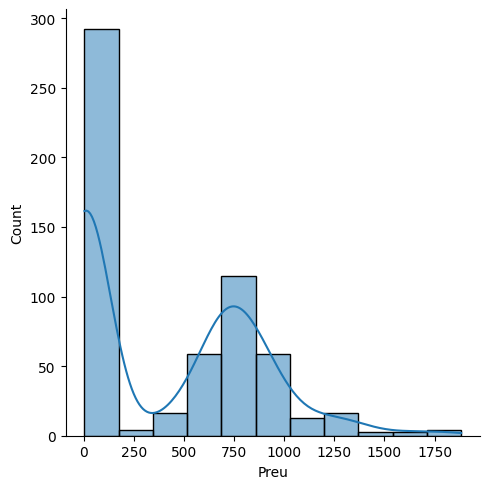

In [18]:
sns.displot(data=precio, x="Preu", kde=True);

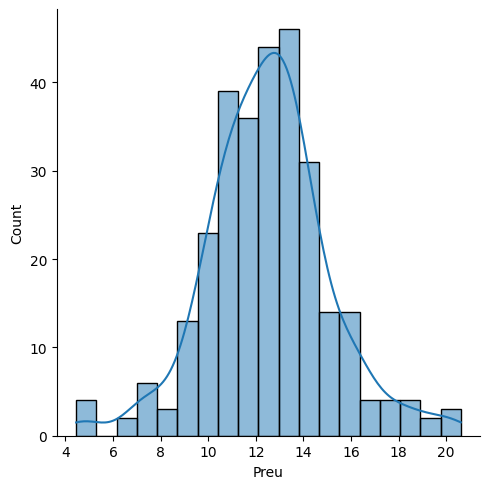

In [19]:
sns.displot(data=precio.loc[precio.LloguerMitja=="M2Mes"], x="Preu", kde=True);

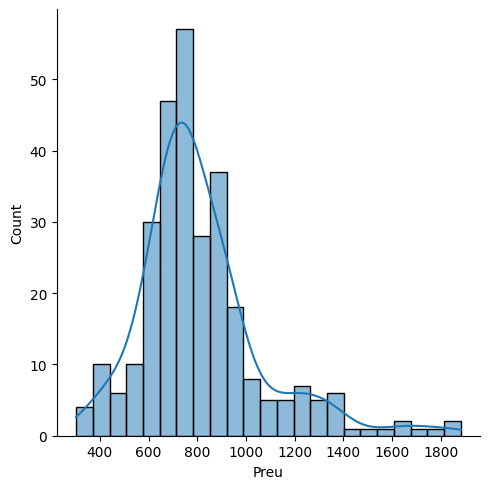

In [20]:
sns.displot(data=precio.loc[precio.LloguerMitja=="Mes"], x="Preu", kde=True);

# 2017_poblacio_exposada_barris_mapa_estrategic_soroll_bcn_long

In [21]:
ruido = pd.read_csv("https://opendata-ajuntament.barcelona.cat/data/dataset/5dfda160-9faa-4a7c-b8fe-c974904ea43b/resource/3846500e-72aa-4780-967f-f09aa184eaba/download/2017_poblacio_exposada_barris_mapa_estrategic_soroll_bcn_long.csv")
ruido.rename(columns=lambda x: x.strip().replace("_", " ").title().replace(" ", ""), inplace=True)
ruido["Valor"] = ruido["Valor"].apply(lambda x: float(x.strip('%'))/100).round(5)
ruido['Concepte'] = ruido['Concepte'].str.replace("GI_TR", "GITR")
ruido = ruido.loc[~(ruido.RangSoroll==">=80 dB")] # eliminar ">=80" porque no hay ninguno
ruido = ruido.replace({'RangSoroll': " dB"}, {'RangSoroll': ""}, regex=True)
ruido = ruido.replace({'RangSoroll': "<40"}, {'RangSoroll': "00-40"}, regex=True)
ruido = ruido.replace({'RangSoroll': "-"}, {'RangSoroll': ""}, regex=True)
ruido['ConcepteRangSoroll'] = ruido['Concepte'].str.split("_" ,expand=True)[0]+ ruido['RangSoroll']+ ruido['Concepte'].str.split("_" ,expand=True)[1]
ruido.drop(columns=["NomDistricte","CodiDistricte", "NomBarri", "RangSoroll", "Concepte"], inplace=True)
ruido["CodiBarri"] = ruido["CodiBarri"].astype("category")
ruido = ruido.pivot(index=['CodiBarri'],columns=["ConcepteRangSoroll"], values='Valor').rename_axis(None, axis=1).reset_index()
ruido.head(2)

,CodiBarri,FFCC0040D,FFCC0040DEN,FFCC0040E,FFCC0040N,FFCC4045D,FFCC4045DEN,FFCC4045E,FFCC4045N,FFCC4550D,...,VIANANTS5560D,VIANANTS5560E,VIANANTS6065D,VIANANTS6065E,VIANANTS6570D,VIANANTS6570E,VIANANTS7075D,VIANANTS7075E,VIANANTS7580D,VIANANTS7580E
0,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0647,0.0602,0.0078,0.0098,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.1919,0.1700,0.0201,0.0173,0.0,0.0,0.0,0.0,0.0,0.0


# Unificación de datos

In [22]:
df = pd.merge(precio, ruido, how="left", on="CodiBarri")
df.drop(columns=['NomDistricte', 'NomBarri'], inplace=True)
df.head(2)

,Trimestre,CodiDistricte,CodiBarri,LloguerMitja,Preu,FFCC0040D,FFCC0040DEN,FFCC0040E,FFCC0040N,FFCC4045D,...,VIANANTS5560D,VIANANTS5560E,VIANANTS6065D,VIANANTS6065E,VIANANTS6570D,VIANANTS6570E,VIANANTS7075D,VIANANTS7075E,VIANANTS7580D,VIANANTS7580E
0,1,1,1,Mes,734.99,1.0,1.0,1.0,1.0,0.0,...,0.0647,0.0602,0.0078,0.0098,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,2,Mes,905.26,1.0,1.0,1.0,1.0,0.0,...,0.1919,0.1700,0.0201,0.0173,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Codificación One-hot de las variables categóricas
df = pd.get_dummies(df)
df.head(2)

,Preu,FFCC0040D,FFCC0040DEN,FFCC0040E,FFCC0040N,FFCC4045D,FFCC4045DEN,FFCC4045E,FFCC4045N,FFCC4550D,...,CodiBarri_66,CodiBarri_67,CodiBarri_68,CodiBarri_69,CodiBarri_70,CodiBarri_71,CodiBarri_72,CodiBarri_73,LloguerMitja_M2Mes,LloguerMitja_Mes
0,734.99,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,905.26,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [49]:
X = df.drop(columns=["Preu"])
y = df[["Preu"]]

In [50]:
# estandarización de las variables
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)
X.head(2)

,FFCC0040D,FFCC0040DEN,FFCC0040E,FFCC0040N,FFCC4045D,FFCC4045DEN,FFCC4045E,FFCC4045N,FFCC4550D,FFCC4550DEN,...,CodiBarri_66,CodiBarri_67,CodiBarri_68,CodiBarri_69,CodiBarri_70,CodiBarri_71,CodiBarri_72,CodiBarri_73,LloguerMitja_M2Mes,LloguerMitja_Mes
0,0.424507,0.437862,0.436104,0.455504,-0.356298,-0.382096,-0.366082,-0.434728,-0.43604,-0.412699,...,-0.117851,-0.117851,-0.117851,-0.117851,-0.117851,-0.117851,-0.117851,-0.117851,-1.0,1.0
1,0.424507,0.437862,0.436104,0.455504,-0.356298,-0.382096,-0.366082,-0.434728,-0.43604,-0.412699,...,-0.117851,-0.117851,-0.117851,-0.117851,-0.117851,-0.117851,-0.117851,-0.117851,-1.0,1.0


In [51]:
# Reducción de dimensionalidad lineal mediante descomposición
pca = PCA(n_components=50)
pca.fit(X)

PCA(n_components=50)

In [52]:
print("Varianza total explicada por {} componentes: {}%".format(50, (pca.explained_variance_ratio_.sum()*100).round(2)))

Total Explained Variance by 50 components: 89.72%


In [53]:
X_pca = pca.transform(X)

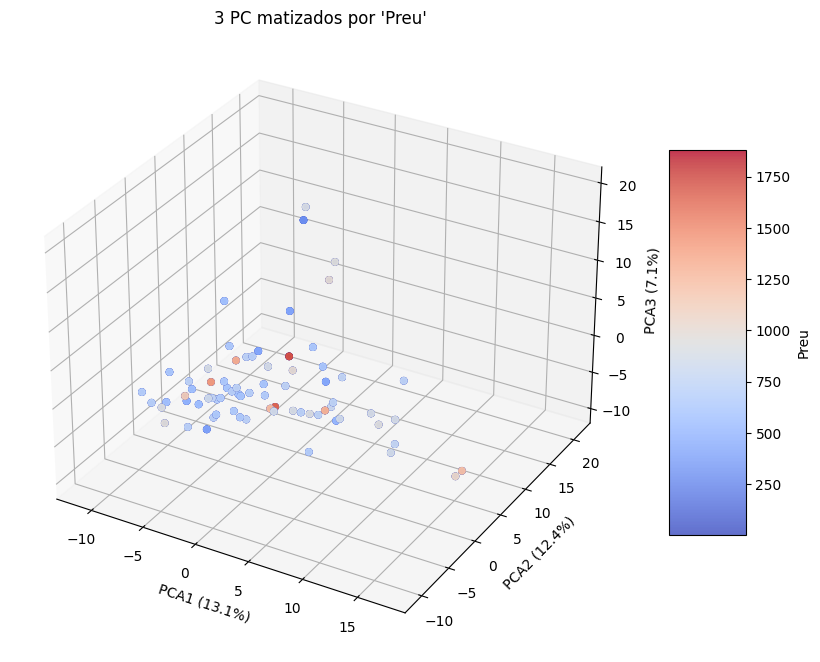

In [61]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.3, alpha = 0.2)
my_cmap = plt.get_cmap('coolwarm')
sctt = ax.scatter3D(X_pca[:,0],
                    X_pca[:,1],
                    X_pca[:,2],
                    alpha = 0.8, c = y, cmap = my_cmap)
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5, label="Preu")
ax.set(xlabel=f"PCA1 ({pca.explained_variance_ratio_[0]*100:.1f}%)",
       ylabel=f"PCA2 ({pca.explained_variance_ratio_[1]*100:.1f}%)",
       zlabel=f"PCA3 ({pca.explained_variance_ratio_[2]*100:.1f}%)",
       title="3 PC matizados por 'Preu'" )
plt.show()

In [62]:
HTML(animation.FuncAnimation(fig, animate, frames=180, interval=50).to_html5_video())

In [54]:
# división de un conjunto de datos en dos bloques de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=123)

In [55]:
# Lista de regresores
regressors =[TransformedTargetRegressor(),PLSRegression(),AdaBoostRegressor(),BaggingRegressor(),
             ExtraTreesRegressor(),GradientBoostingRegressor(),HistGradientBoostingRegressor(),
             RandomForestRegressor(),GaussianProcessRegressor(),ARDRegression(),HuberRegressor(),
             LinearRegression(),PassiveAggressiveRegressor(),PoissonRegressor(),SGDRegressor(),
             TheilSenRegressor(),KNeighborsRegressor(),MLPRegressor(),DecisionTreeRegressor(),
             ExtraTreeRegressor(),SVR(),BayesianRidge()]

regressors_df = pd.DataFrame([str(regressor) for regressor in regressors], columns=["regressor"])
np.random.seed(42)

for regressor in regressors:
    regressor.fit(X_train, y_train)
    preds = regressor.predict(X_test)
    r2=r2_score(y_test, preds).round(3)
    mae=mean_absolute_error(y_test, preds).round(3)
    rmse=np.sqrt(mean_squared_error(y_test, preds)).round(3)
    print('{}\nR2:{}  MAE:{} RMSE:{}\n'.format(str(regressor), r2, mae, rmse))
    regressors_df.loc[regressors_df.regressor==str(regressor),["R2", "MAE", "RMSE"]]=(r2, mae, rmse)

TransformedTargetRegressor()
R2:0.866  MAE:111.974 RMSE:164.337

PLSRegression()
R2:0.861  MAE:112.337 RMSE:167.498

AdaBoostRegressor()
R2:0.96  MAE:53.22 RMSE:90.202

BaggingRegressor()
R2:0.984  MAE:28.324 RMSE:56.411

ExtraTreesRegressor()
R2:0.991  MAE:19.885 RMSE:42.137

GradientBoostingRegressor()
R2:0.99  MAE:27.812 RMSE:44.608

HistGradientBoostingRegressor()
R2:0.973  MAE:36.308 RMSE:74.294

RandomForestRegressor()
R2:0.989  MAE:23.174 RMSE:47.296

GaussianProcessRegressor()
R2:-0.745  MAE:393.369 RMSE:593.64

ARDRegression()
R2:0.864  MAE:112.286 RMSE:165.796

HuberRegressor()
R2:0.81  MAE:115.052 RMSE:196.1

LinearRegression()
R2:0.866  MAE:111.974 RMSE:164.337

PassiveAggressiveRegressor()
R2:0.747  MAE:138.392 RMSE:225.992

PoissonRegressor()
R2:0.979  MAE:36.114 RMSE:65.803

SGDRegressor()
R2:0.842  MAE:120.478 RMSE:178.665

TheilSenRegressor()
R2:0.398  MAE:228.01 RMSE:348.574

KNeighborsRegressor()
R2:0.039  MAE:394.646 RMSE:440.633

MLPRegressor()
R2:0.003  MAE:381.48

In [56]:
# Resultados ordenados por R2
regressors_df.sort_values(by="R2", ascending=False)

,regressor,R2,MAE,RMSE
4,ExtraTreesRegressor(),0.991,19.885,42.137
5,GradientBoostingRegressor(),0.990,27.812,44.608
7,RandomForestRegressor(),0.989,23.174,47.296
18,DecisionTreeRegressor(),0.989,22.163,46.439
3,BaggingRegressor(),0.984,28.324,56.411
13,PoissonRegressor(),0.979,36.114,65.803
19,ExtraTreeRegressor(),0.975,31.829,70.421
6,HistGradientBoostingRegressor(),0.973,36.308,74.294
2,AdaBoostRegressor(),0.960,53.220,90.202
0,TransformedTargetRegressor(),0.866,111.974,164.337


In [57]:
# Seleccionamos el regresor "ExtraTreesRegressor"
model = ExtraTreesRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)
r2=r2_score(y_test, preds).round(3)
mae=mean_absolute_error(y_test, preds).round(3)
rmse=np.sqrt(mean_squared_error(y_test, preds)).round(3)
print('{}\nR2:{}  MAE:{} RMSE:{}\n'.format(str(regressor), r2, mae, rmse))

BayesianRidge()
R2:0.991  MAE:19.422 RMSE:41.474



In [58]:
# Guardamos el modelo
dump(model, 'regressor.joblib')

['regressor.joblib']

In [59]:
y_test["PreuPreds"] = preds

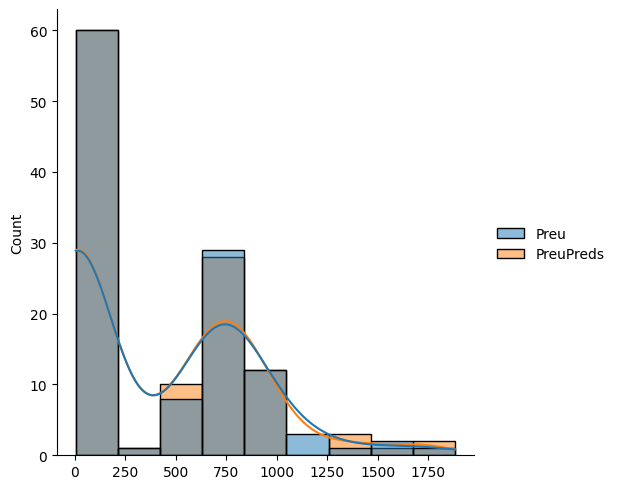

In [60]:
# Comparación gráfica de las prediciiones y los valores reales
sns.displot(data=y_test, kde=True);